# 

In [2]:
import numpy as np
import os

from matplotlib import pyplot as plt


In [3]:


def get_pure_output_paths(history_path):

    output_dirs = ["/data/dust/user/dayhallh/CC2-out/",
                   "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sampling/"]
    paths = []

    split_path = history_path.split('/')
    dataset_name = split_path[-2]
    model_name = split_path[-1][11:-11]
    prefix = f"pureShowerflow_{dataset_name}_{model_name}0"
    for output_dir in output_dirs:
        
        paths += [os.path.join(output_dir, f) for f in os.listdir(output_dir) if prefix in f and f.endswith("npz")]

    return prefix, paths



def get_cog_values(prefix, paths, cog_idx=2, npz_format=True):
    
    iteration = np.fromiter((int(f.split(prefix)[-1].split('_')[0]) for f in paths), dtype=int)
    order = np.argsort(iteration)
    iteration = iteration[order]

    if npz_format:
        cog = [np.load(f)['showerflow_out'][:, cog_idx] for f in paths]
        wass = [np.atleast_1d(np.load(f)['wass']) for f in paths]
    else:
        cog = [np.load(f)[:, cog_idx] for f in paths]
        wass = None
    trim_to = np.min([len(c) for c in cog])
    cog = np.vstack([c[:trim_to] for c in cog])[order]


    mean_cog = np.mean(cog, axis=1)
    std_cog = np.std(cog, axis=1)
    centered = cog - np.mean(mean_cog)
    max_devation = np.max(np.abs(centered), axis=1)
    return iteration, std_cog, max_devation, wass


def plot_history(history_paths, title, ax_arr=None, history_labels=None, colours=None, logx=True, **kwargs):
    
    if isinstance(history_paths, str):
        history_paths = [history_paths]

    if history_labels is None:
        history_labels = [None for _ in history_paths]
        
    if colours is None:
        colours = plt.cm.tab10(np.linspace(0,1,10))
    
    cog_values = []
    has_any_pure = False
    for history_path in history_paths:
        prefix, paths = get_pure_output_paths(history_path)
        if paths:
            print("Found cog data")
            has_any_pure = True
            cog_values.append(get_cog_values(prefix, paths))
        else:
            print("No cog data")
            cog_values.append(None)

    labels = ["loss", "mean parameter", "max parameter", "gradient normal",]

    if has_any_pure:
        labels += ["std/max devation CoG x", "sliced Wasserstein"]

    if ax_arr is None:
        if has_any_pure:
            fig, ax_arr = plt.subplots(3, 2, sharex=True, figsize=(15, 8))
            ax_arr[2, 0].semilogy()
            ax_arr[2, 1].semilogy()
        else:
            fig, ax_arr = plt.subplots(2, 2, sharex=True, figsize=(15, 7))
    else:
        fig = plt.gcf()


    can_log = True
    nan_label = 'nan frequency'

    nan_axis = [ax.twinx() for ax in ax_arr[:2].flatten()]
    [ax.set_ylabel("Nan counts") for ax in nan_axis]

    ax_y_ranges = np.zeros((4, 2))
    ax_y_ranges[:, 0] = 100
    for h, history_path in enumerate(history_paths):
        history = np.load(history_path)
        epoch = history[0]
        for i, ax in enumerate(ax_arr[:2].flatten()):
            ax.plot(epoch, history[i+1], c=colours[h], alpha=0.6, label=history_labels[h])
            ax_y_ranges[i, 0] = min(np.nanmin(history[i+1]), ax_y_ranges[i, 0])
            ax_y_ranges[i, 1] = max(np.nanmax(history[i+1]), ax_y_ranges[i, 1])
            
    for h, history_path in enumerate(history_paths):
        best_data_path = history_path.replace("_history.npy", "_best_data.txt")
        with open(best_data_path, 'r') as f:
            best_loss, best_epoch = f.read().split()
        best_loss = float(best_loss)
        best_epoch = int(best_epoch)
        print(f"Best loss {best_loss} at {best_epoch}")
        
        history = np.load(history_path)
        
        epoch = history[0]
        for i, ax in enumerate(ax_arr[:2].flatten()):
            y_min, y_max = ax_y_ranges[i]

            ax.vlines(best_epoch, y_min, y_max, color='k')
            ax.vlines(best_epoch, y_min, y_max, color=colours[h], linestyles='--')

            nan_locations = epoch[np.where(np.isnan(history[i+1]))[0]]
            nan_axis[i].hist(nan_locations, bins=20, histtype='step', color=colours[h])
            nan_label=None
            
    
        if not np.all(history[1]>0):
            can_log = False
        if cog_values[h] is not None:
            iteration, cog, max_dev, wass = cog_values[h]
            ax_arr[2, 0].plot(iteration, cog, c=colours[h], label=history_labels[h])
            ax_arr[2, 0].plot(iteration, max_dev, c=colours[h], ls='--', label=history_labels[h])
            wass_iter = [i for i, w in zip(iteration, wass) for _ in w]
            flat_wass = [w for event in wass for w in event if event.shape]               
            ax_arr[2, 1].scatter(wass_iter, flat_wass, c=colours[h], label=history_labels[h])
    
    for i, ax in enumerate(ax_arr.flatten()):
        if f"ax{i}_ylim" in kwargs:
            ax.set_ylim(*kwargs[f"ax{i}_ylim"])
        if logx:
            ax.semilogx()
        ax.set_xlabel("iteration (100k events)")
        ax.set_ylabel(labels[i])
        ax.grid(True, which='both')
    ax_arr[0, 1].legend()
    if can_log:
        if logx:
            ax_arr[0, 0].loglog()
        else:
            ax_arr[0, 0].semilogy()
    if logx:
        xmin, xmax = ax_arr[0, 0].get_xlim()
        ax_arr[0, 0].set_xlim(10, xmax)
    fig.suptitle(title)
    fig.tight_layout()
    return fig, ax_arr


No cog data
Best loss 223625.703125 at 234701
No cog data
Best loss inf at 91457


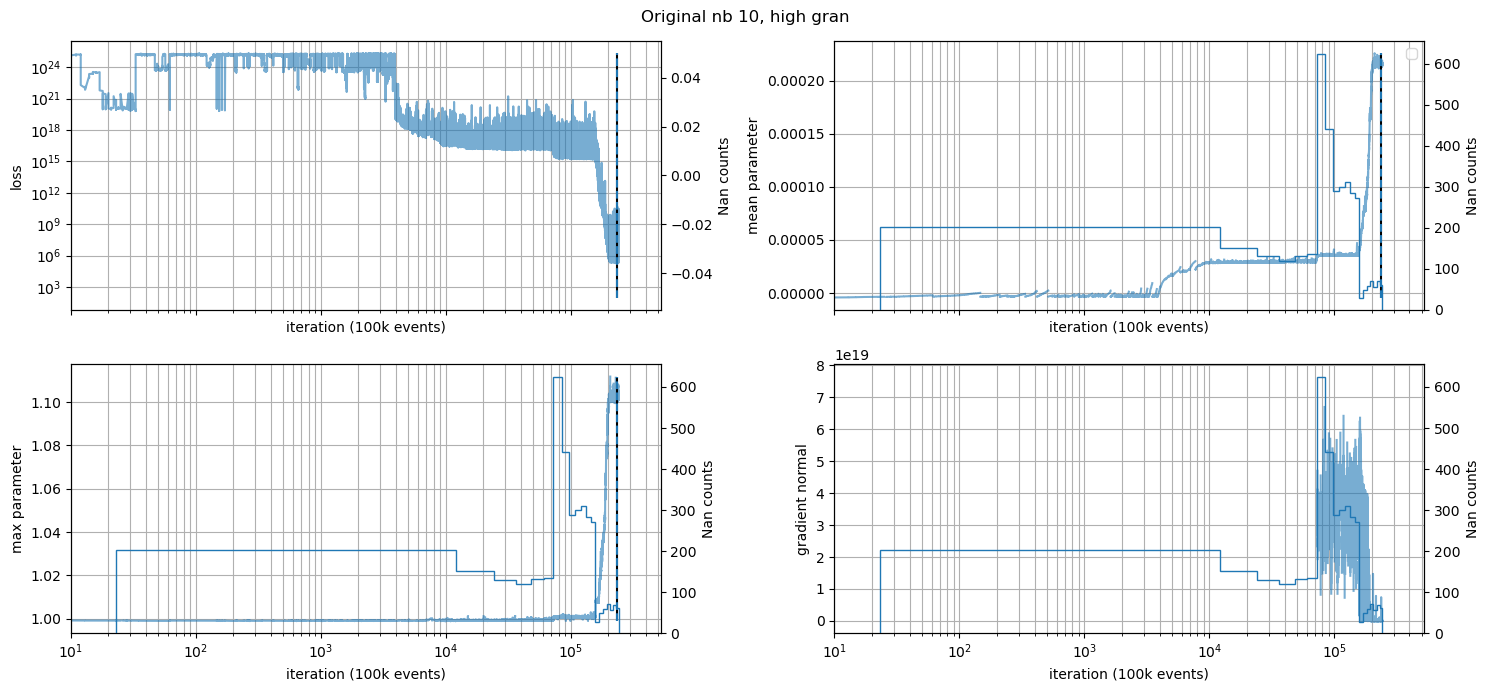

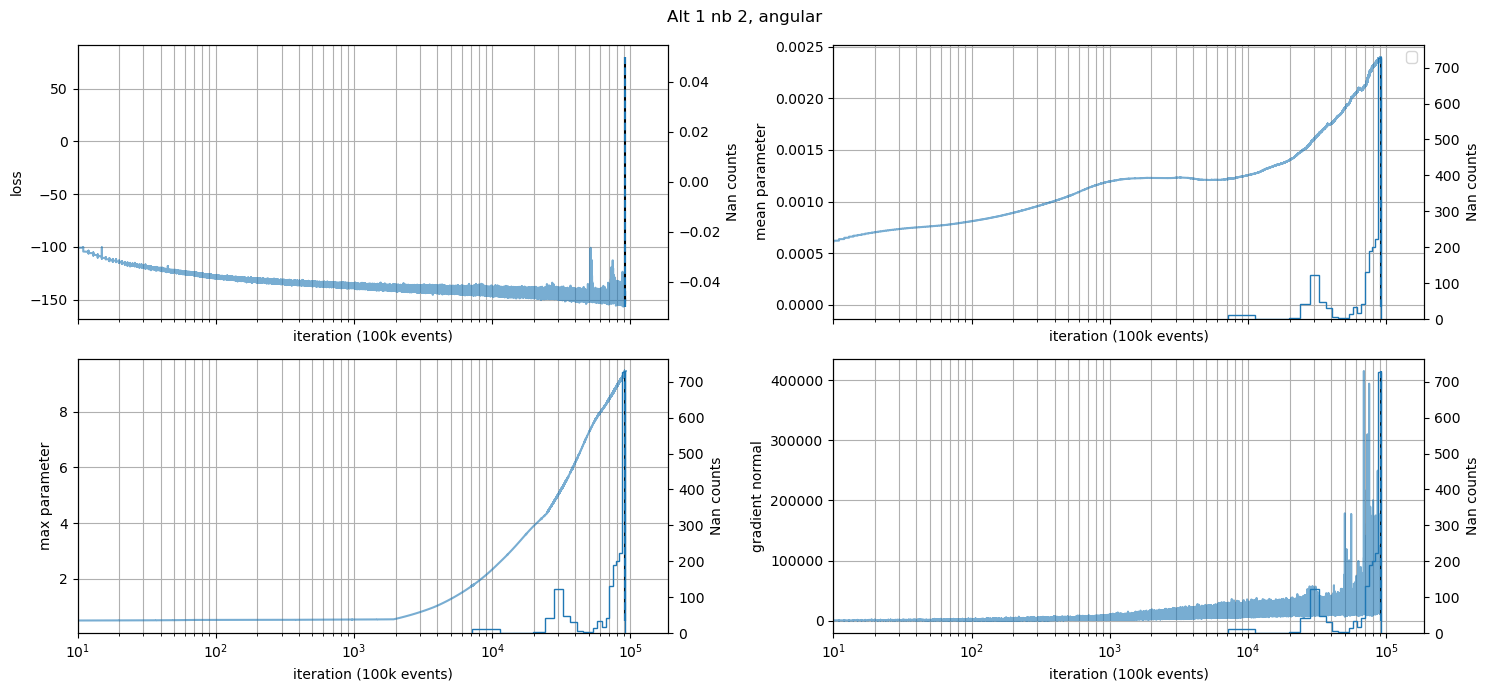

In [89]:


history_path1 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/highGran_g40_p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_history.npy"
labels = ["Original nb 10, high gran", "Alt 1 nb 2, angular"]
title="Try 2"

history_path2 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_history.npy"
fig, ax_arr = plot_history([history_path1], labels[0])
fig, ax_arr = plot_history([history_path2], labels[1])

Found cog data
Best loss -291.8370361328125 at 181814


(<Figure size 1500x800 with 10 Axes>,
 array([[<Axes: xlabel='iteration (100k events)', ylabel='loss'>,
         <Axes: xlabel='iteration (100k events)', ylabel='mean parameter'>],
        [<Axes: xlabel='iteration (100k events)', ylabel='max parameter'>,
         <Axes: xlabel='iteration (100k events)', ylabel='gradient normal'>],
        [<Axes: xlabel='iteration (100k events)', ylabel='std/max devation CoG x'>,
         <Axes: xlabel='iteration (100k events)', ylabel='sliced Wasserstein'>]],
       dtype=object))

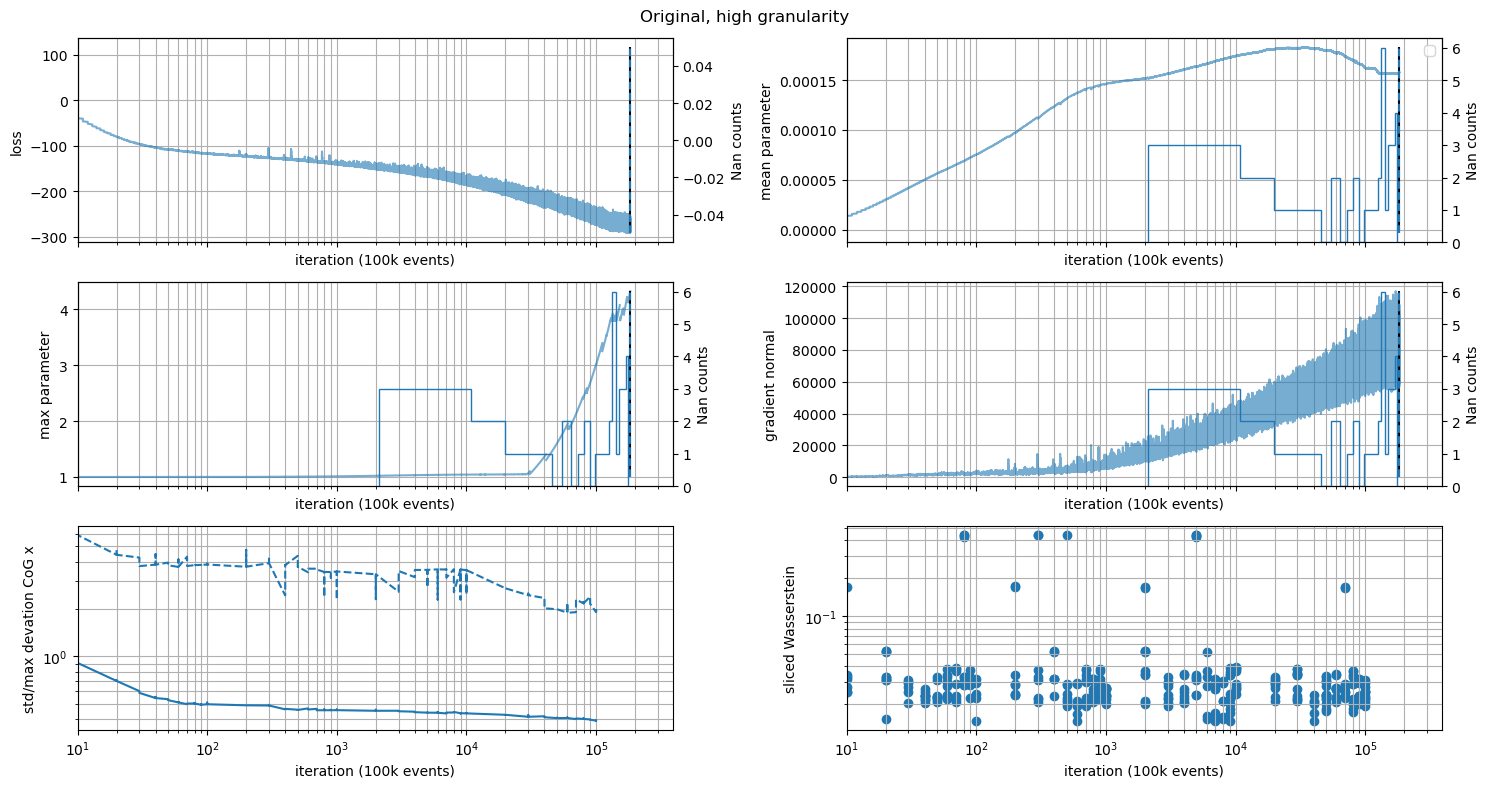

In [103]:
history_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/highGran_g40_p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_try8_history.npy"
title = "Original, high granularity"
plot_history(history_path, title)




Found cog data
Found cog data
Found cog data
Best loss -291.8370361328125 at 181814
Best loss -137.03887939453125 at 9485
Best loss -151.14430236816406 at 89369


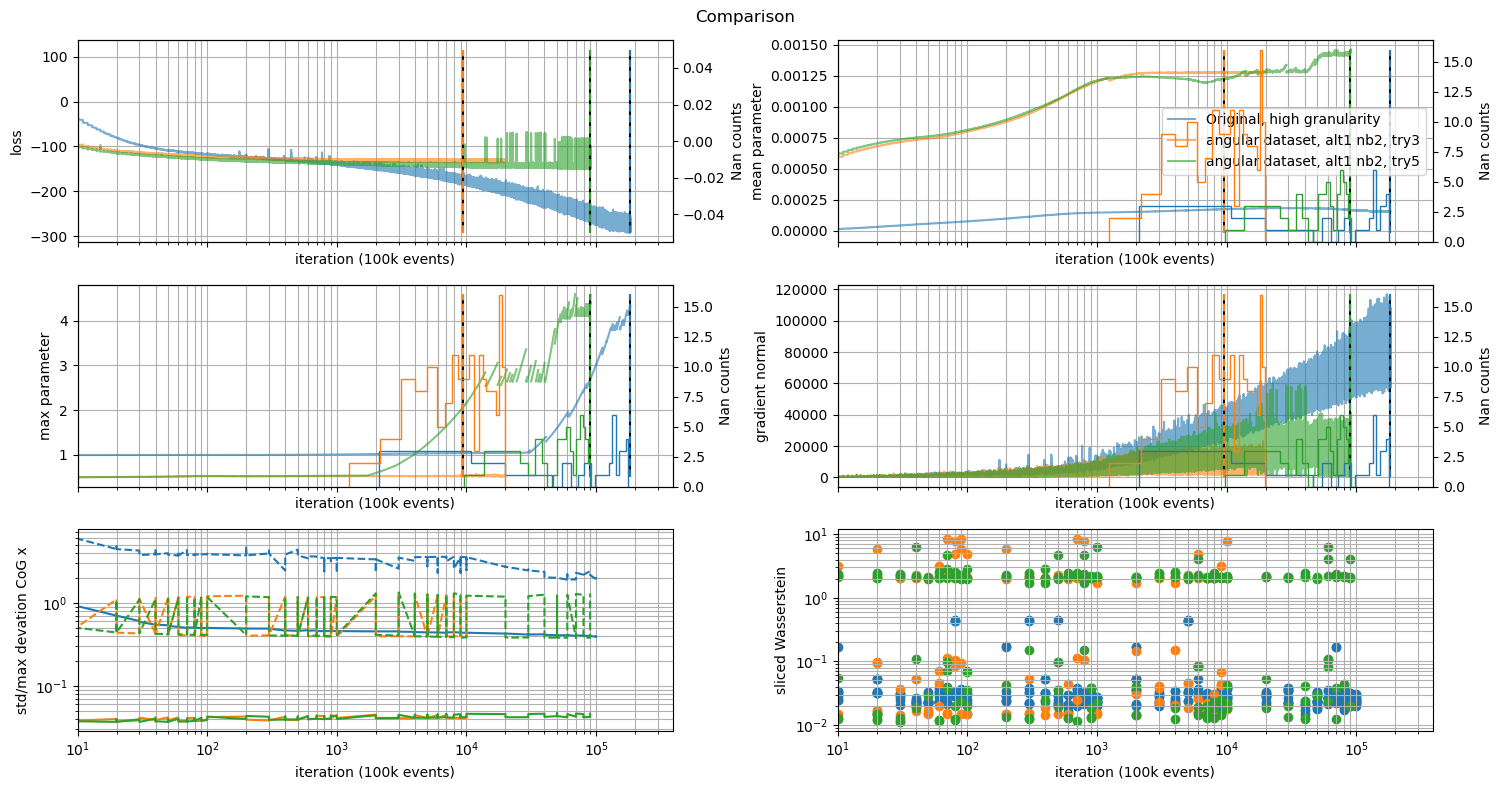

In [104]:
history_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/highGran_g40_p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_try8_history.npy"
title = "Original, high granularity"
history_path3 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try3_me10_history.npy"
title3 = "angular dataset, alt1 nb2, try3"
#history_path1 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs1152921504606846975_fnorms_dhist_try4_history.npy"
title1 = "angular dataset, alt1 nb2, try4 - no CoG"
history_path4 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try5_history.npy"
title4 = "angular dataset, alt1 nb2, try5"
fig, ax_arr = plot_history([history_path, history_path3, history_path4], "Comparison", history_labels=[title, title3, title4])

Found cog data
Found cog data
Found cog data
Best loss -193.23080444335938 at 8094
Best loss -140.93446350097656 at 6899
Best loss -137.03887939453125 at 9485


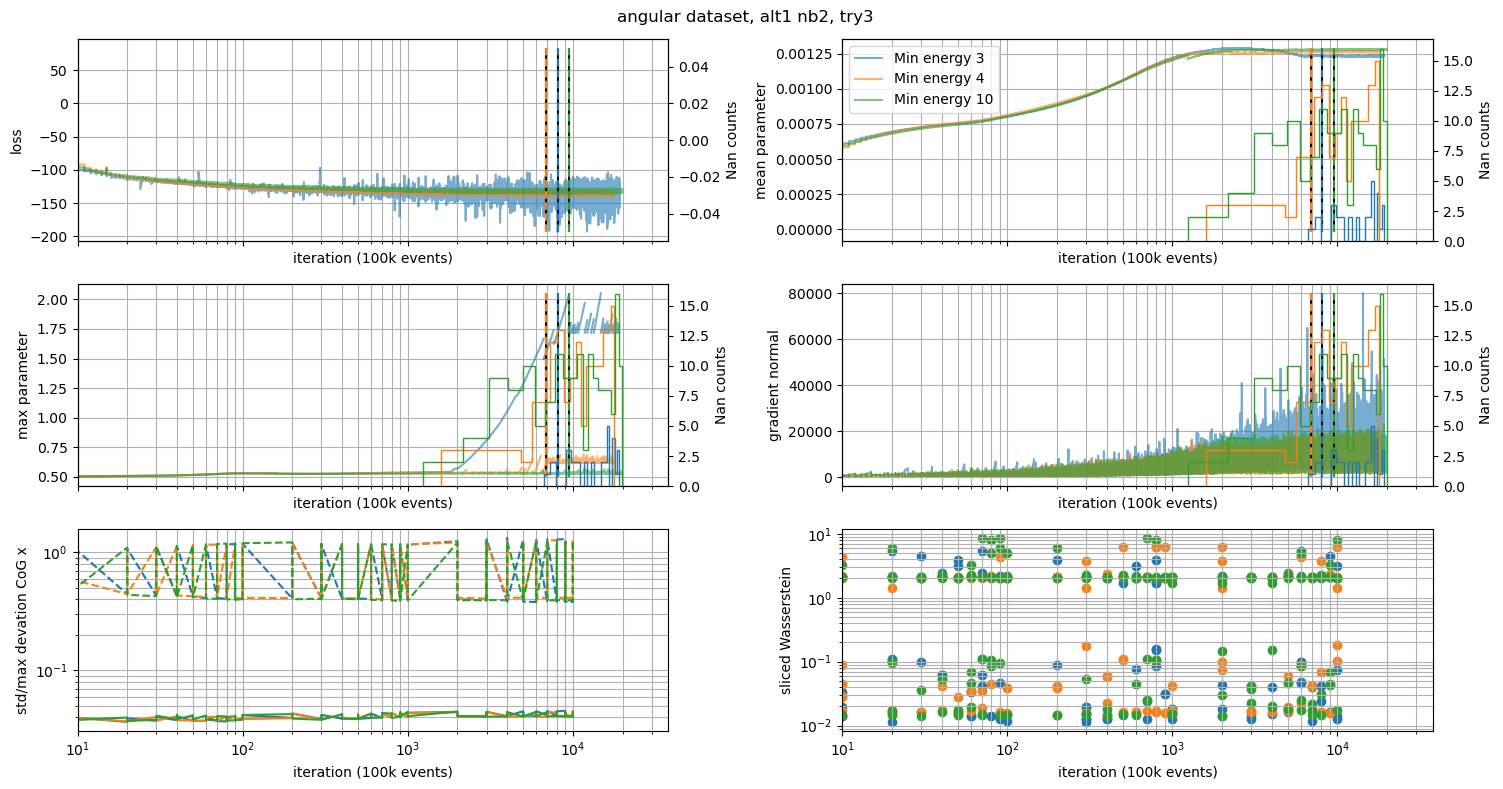

In [105]:
history_path1 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try3_me3_history.npy"
history_path2 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try3_me4_history.npy"
history_path3 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try3_me10_history.npy"
title = "angular dataset, alt1 nb2, try3"
labels = ["Min energy 3", "Min energy 4", "Min energy 10"]
fig, ax_arr = plot_history([history_path1, history_path2, history_path3], title, history_labels=labels)


No cog data
Best loss -149.06082153320312 at 47969


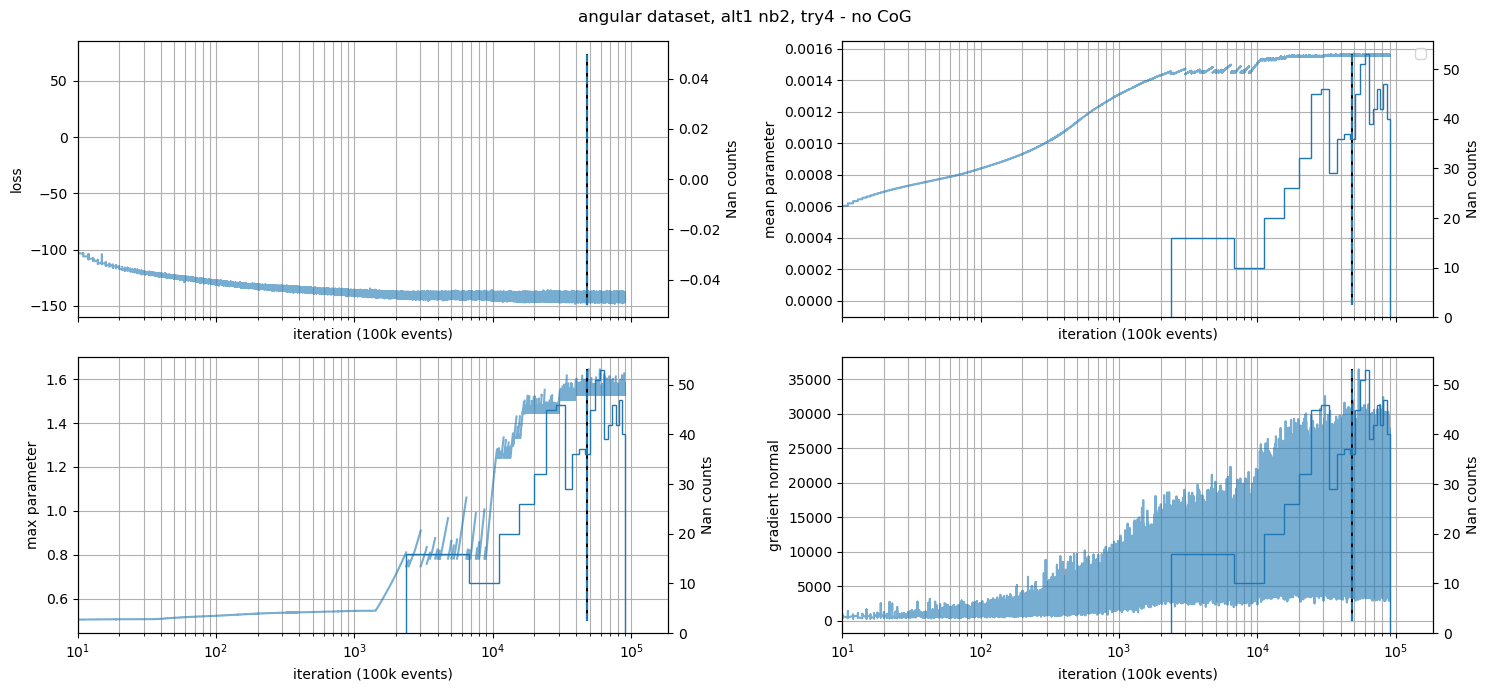

In [94]:
history_path1 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs1152921504606846975_fnorms_dhist_try4_history.npy"
title = "angular dataset, alt1 nb2, try4 - no CoG"
fig, ax_arr = plot_history([history_path1], title)

Found cog data
Best loss -151.14430236816406 at 89369


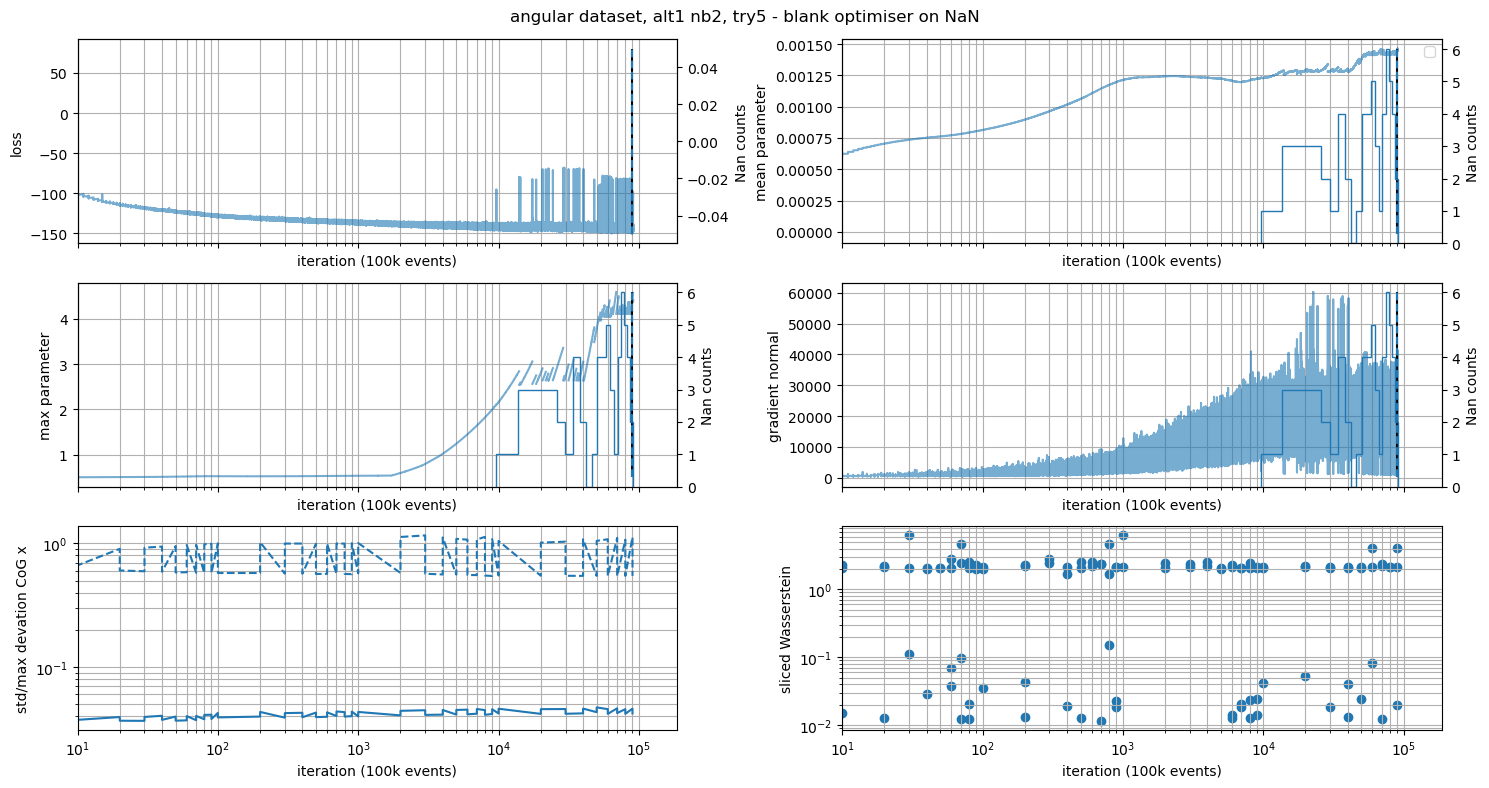

In [95]:
history_path1 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try5_history.npy"
title = "angular dataset, alt1 nb2, try5 - blank optimiser on NaN"
fig, ax_arr = plot_history([history_path1], title)

Found cog data
Best loss -183.3745574951172 at 80969


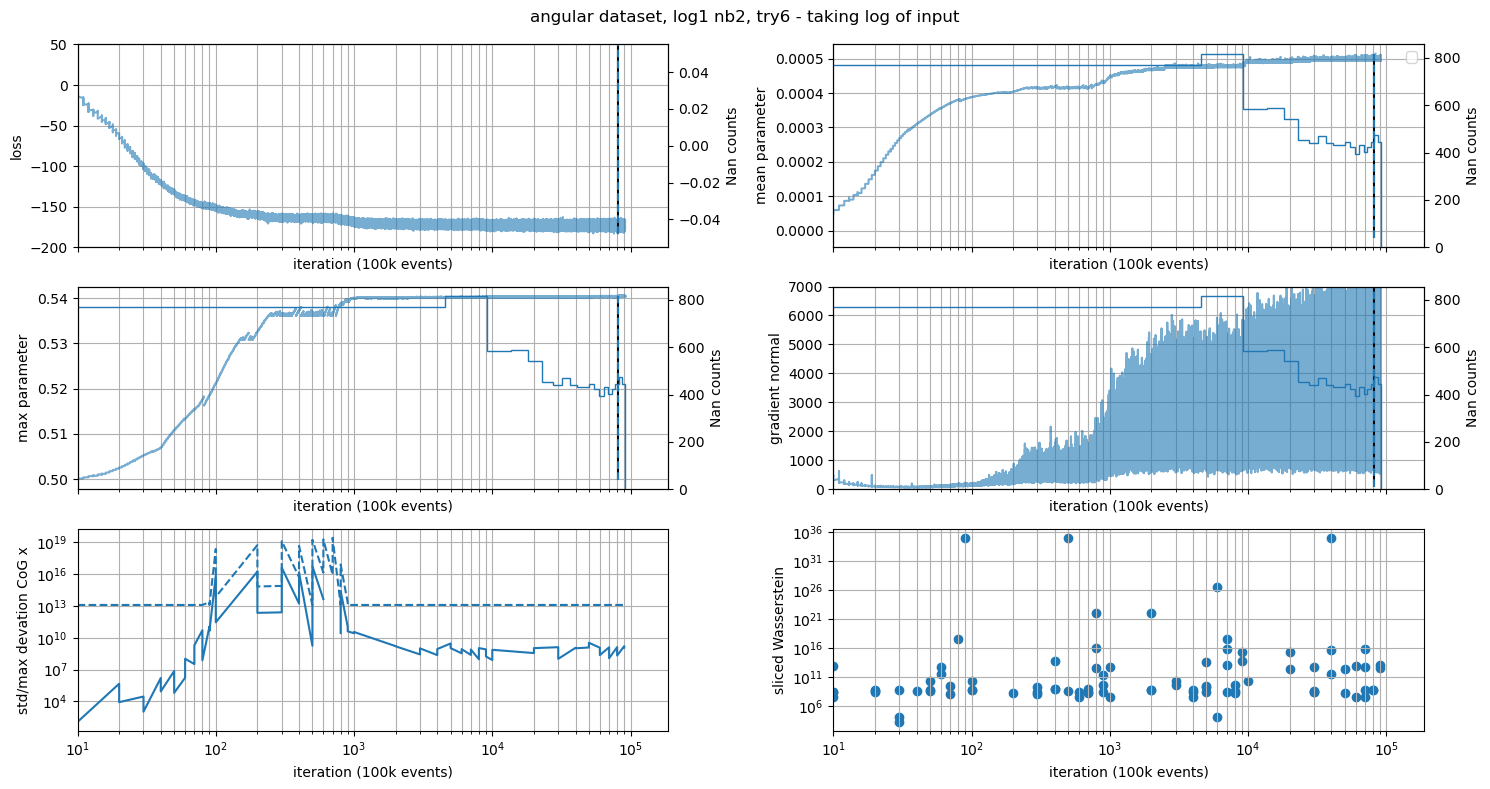

In [96]:
history_path1 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_log1_nb2_inputs8070450532247928831_fnorms_dhist_try6_history.npy"
title = "angular dataset, log1 nb2, try6 - taking log of input"
fig, ax_arr = plot_history([history_path1], title, ax0_ylim=(-200, 50), ax3_ylim=(0, 7_000))

Found cog data
Found cog data
Best loss -301.1246643066406 at 205408
Best loss -148.38711547851562 at 21719


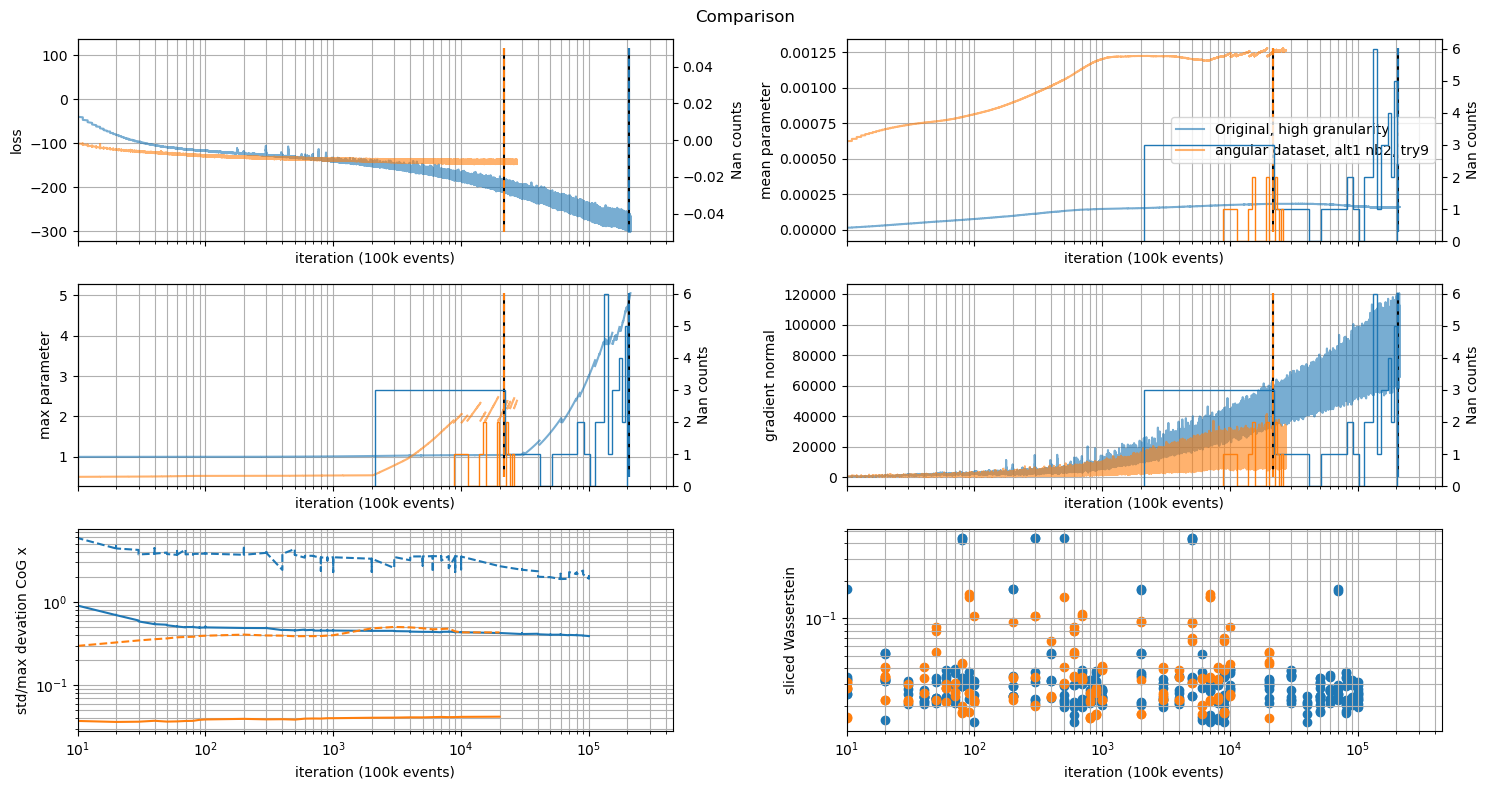

In [5]:
history_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/highGran_g40_p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_try8_history.npy"
title = "Original, high granularity"
history_path3 = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_try9_history.npy"
title3 = "angular dataset, alt1 nb2, try9"
fig, ax_arr = plot_history([history_path, history_path3], "Comparison", history_labels=[title, title3])